In [1]:
#Import packages
import seaborn as sns
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#LDA Coherence scores
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

#NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Data Splitting and Resampling
from sklearn.model_selection import train_test_split

# Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Reports
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Model
from sklearn import svm

In [2]:
filtered_df = pd.read_csv('tfidf_text_final.csv')

In [3]:
filtered_df.head()

,text,type,tfidf_text
0,database project affect environment affect pro...,database,database project affect environment affect pro...
1,sql stick production seem like sql stuck produ...,database,sql stick production seem like sql stuck produ...
2,database medium folder migration stage able re...,database,database medium folder migration stage able re...
3,sql server go away error log addition previous...,database,sql server go away error log previous message ...
4,location fail graph overall elastic monitor si...,database,location fail graph elastic monitor sincerely ...


In [4]:
filtered_df['tfidf_text'].isnull().sum()


1

In [5]:
filtered_df.dropna(subset=['tfidf_text'], inplace=True)


In [6]:
######LDA model from gensim

# Set seeds for reproducibility
random.seed(35)
np.random.seed(35)

# Preprocess the text data
processed_docs = filtered_df['tfidf_text'].apply(lambda x: simple_preprocess(x))

# Create a CountVectorizer object
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(filtered_df['tfidf_text'])

# Create a Gensim Dictionary
id2word = Dictionary(processed_docs)

# Convert the text data to a Gensim corpus
corpus = [id2word.doc2bow(doc) for doc in processed_docs]

# Initialize variables
start_topics = 9
end_topics = 12
coherence_scores = []

# Iterate over different numbers of topics
for num_topics in range(start_topics, end_topics + 1):
    # Create LDA model using Gensim
    lda = LdaModel(corpus, id2word=id2word, num_topics=num_topics)

    # Get coherence score
    coherence_model = CoherenceModel(model=lda, texts=processed_docs, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

# Print coherence scores for different numbers of topics
print("\nCoherence Scores:")
for num_topics, score in zip(range(start_topics, end_topics + 1), coherence_scores):
    print(f"Number of Topics: {num_topics}, Coherence Score: {score}")


Coherence Scores:
Number of Topics: 9, Coherence Score: 0.4696864439674392
Number of Topics: 10, Coherence Score: 0.4828995848700252
Number of Topics: 11, Coherence Score: 0.47724307973085267
Number of Topics: 12, Coherence Score: 0.44479144205601573


In [7]:

# Set seeds for reproducibility
random.seed(24)
np.random.seed(24)

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_df['tfidf_text'])

# Apply NMF to the TF-IDF matrix
num_topics = 10 # specify the number of topics/clusters
nmf_model = NMF(n_components=num_topics)
nmf_matrix = nmf_model.fit_transform(tfidf_matrix)

# Get the top words for each topic
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model.components_):
    print(f"Topic {topic_idx + 1}:")
    print([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]])

/Users/swap7898/Applications/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Topic 1:
['deploy', 'fail', 'magento', 'error', 'stick', 'integration', 'cloud', 'composer', 'stuck', 'tool']
Topic 2:
['fastly', 'domain', 'cache', 'block', 'add', 'service', 'configuration', 'snippet', 'page', 'solution']
Topic 3:
['upsize', 'size', 'production', 'temporary', 'resize', 'false', 'infrastructure', 'change', 'schedule', 'date']
Topic 4:
['space', 'disk', 'increase', 'redis', 'storage', 'app', 'export', 'share', 'pub', 'medium']
Topic 5:
['elastic', 'search', 'open', 'number', 'analysis', 'curl', 'product', 'build', 'type', 'install']
Topic 6:
['database', 'backup', 'dump', 'production', 'snap', 'maria', 'table', 'vol', 'create', 'user']
Topic 7:
['sendgrid', 'domain', 'record', 'send', 'mail', 'add', 'net', 'account', 'verify', 'cloud']
Topic 8:
['upgrade', 'version', 'maria', 'service', 'production', 'staging', 'environment', 'change', 'infrastructure', 'schedule']
Topic 9:
['memory', 'cache', 'human', 'redis', 'key', 'magento', 'product', 'connection', 'error', 'peak'

In [8]:
# Get the indices of the dominant topics for each document
dominant_topics = nmf_matrix.argmax(axis=1)

# Add a new column 'topic' to the DataFrame and assign the dominant topic for each document
filtered_df['topic'] = dominant_topics

# Display the DataFrame with the assigned topics
filtered_df.head()


,text,type,tfidf_text,topic
0,database project affect environment affect pro...,database,database project affect environment affect pro...,5
1,sql stick production seem like sql stuck produ...,database,sql stick production seem like sql stuck produ...,9
2,database medium folder migration stage able re...,database,database medium folder migration stage able re...,5
3,sql server go away error log addition previous...,database,sql server go away error log previous message ...,9
4,location fail graph overall elastic monitor si...,database,location fail graph elastic monitor sincerely ...,1


In [9]:
filtered_df['topic'].value_counts()

0    3540
1    2311
2    2193
4    2139
3    1939
8    1769
5    1767
7    1315
9    1029
6     920
Name: topic, dtype: int64

In [10]:
# Assign names to each topic
filtered_df.loc[filtered_df['topic'] == 0, 'topic'] = 'Deploy'
filtered_df.loc[filtered_df['topic'] == 1, 'topic'] = 'Fastly'
filtered_df.loc[filtered_df['topic'] == 2, 'topic'] = 'Upsize'
filtered_df.loc[filtered_df['topic'] == 3, 'topic'] = 'Resources'
filtered_df.loc[filtered_df['topic'] == 4, 'topic'] = 'Elasticsearch'
filtered_df.loc[filtered_df['topic'] == 5, 'topic'] = 'database'
filtered_df.loc[filtered_df['topic'] == 6, 'topic'] = 'Sendgrid'
filtered_df.loc[filtered_df['topic'] == 7, 'topic'] = 'Upgrade_services'
filtered_df.loc[filtered_df['topic'] == 8, 'topic'] = 'Redis'
filtered_df.loc[filtered_df['topic'] == 9, 'topic'] = 'Database_Admin'

In [11]:
filtered_df.head()

,text,type,tfidf_text,topic
0,database project affect environment affect pro...,database,database project affect environment affect pro...,database
1,sql stick production seem like sql stuck produ...,database,sql stick production seem like sql stuck produ...,Database_Admin
2,database medium folder migration stage able re...,database,database medium folder migration stage able re...,database
3,sql server go away error log addition previous...,database,sql server go away error log previous message ...,Database_Admin
4,location fail graph overall elastic monitor si...,database,location fail graph elastic monitor sincerely ...,Fastly


In [12]:
filtered_df['topic'].value_counts()

Deploy              3540
Fastly              2311
Upsize              2193
Elasticsearch       2139
Resources           1939
Redis               1769
database            1767
Upgrade_services    1315
Database_Admin      1029
Sendgrid             920
Name: topic, dtype: int64

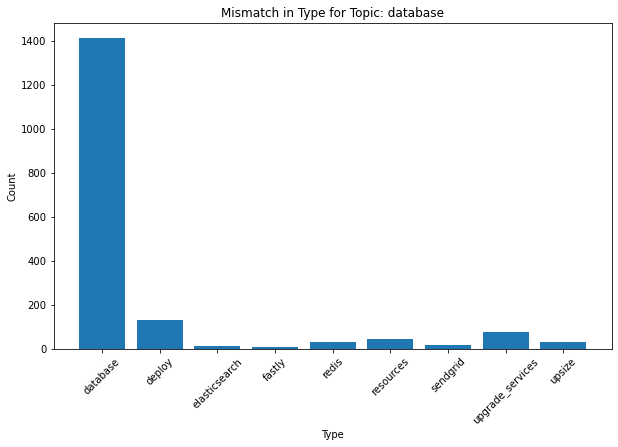

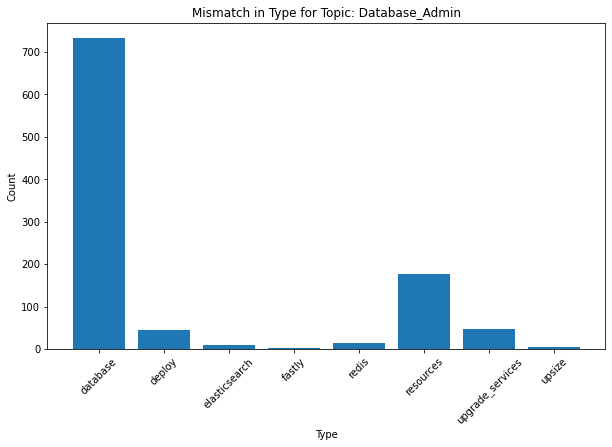

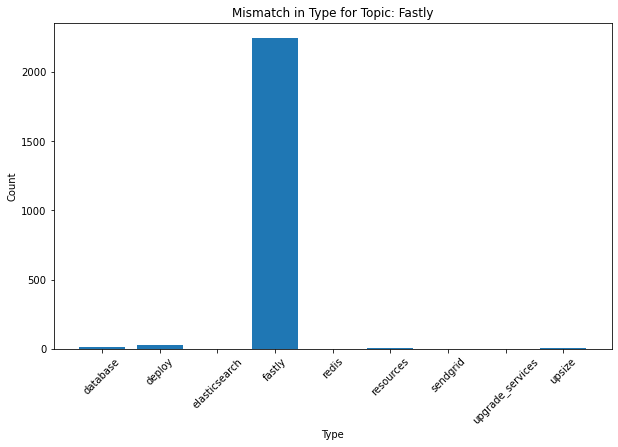

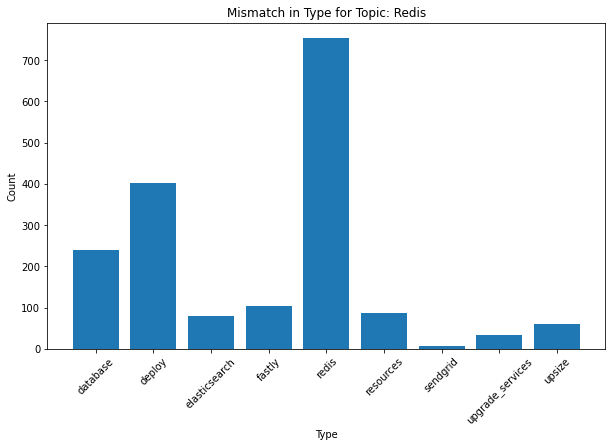

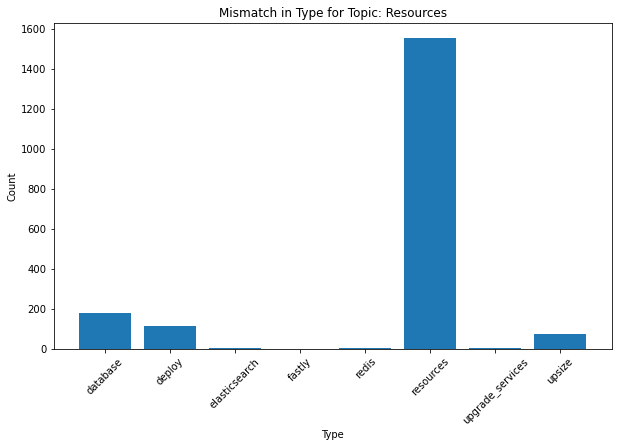

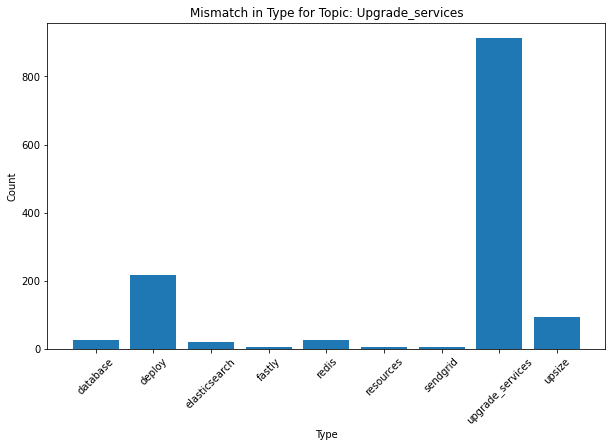

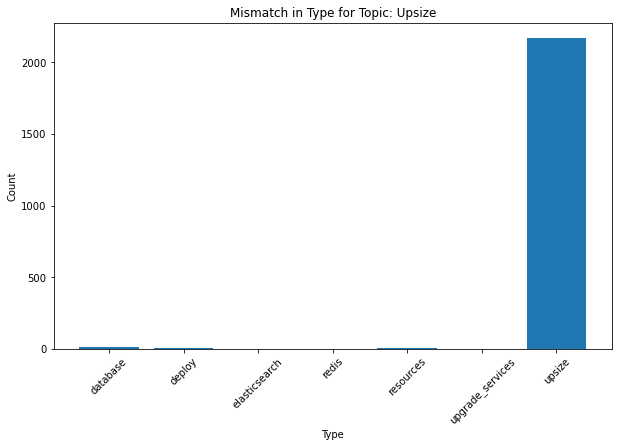

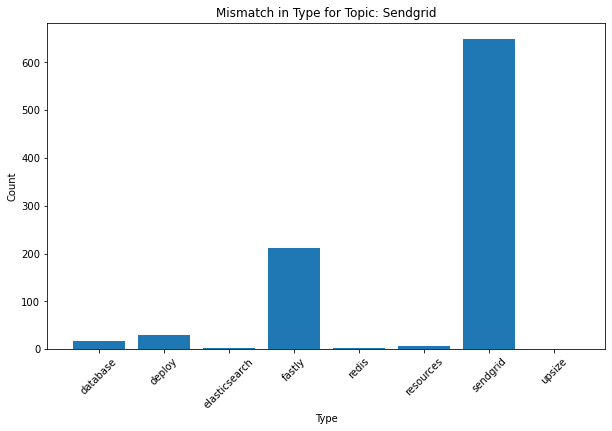

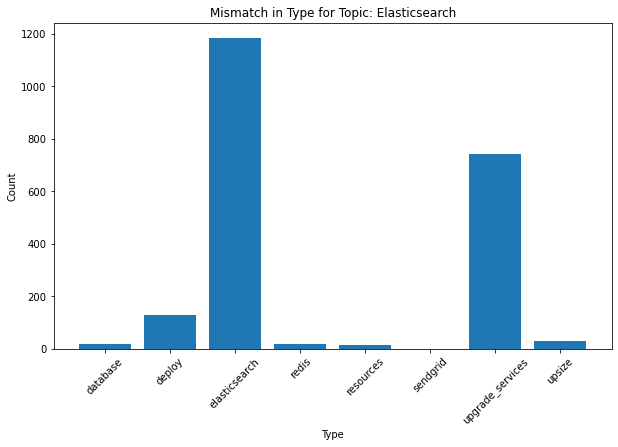

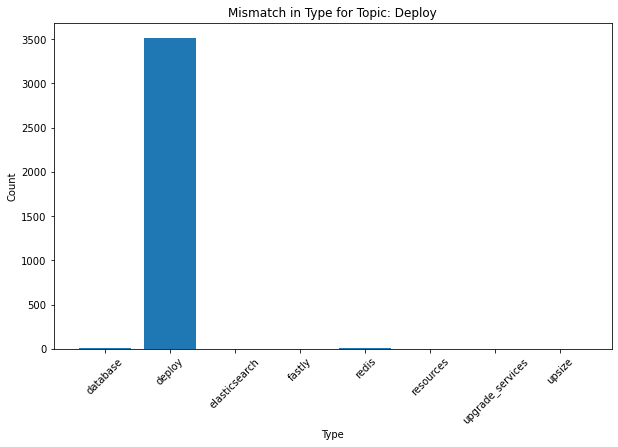

In [13]:
# Group the data by 'topic' and 'type' and count the occurrences
topic_type_counts = filtered_df.groupby(['topic', 'type']).size().reset_index(name='count')

# Create a bar chart for each topic
for topic in filtered_df['topic'].unique():
  # Filter the data for the current topic
  topic_data = topic_type_counts[topic_type_counts['topic'] == topic]
  plt.figure(figsize=(10,6))
  # Create a bar chart
  plt.bar(topic_data['type'], topic_data['count'])
  plt.xticks(rotation=45)
  # Set the x-axis label
  plt.xlabel('Type')

  # Set the y-axis label
  plt.ylabel('Count')

  # Set the title of the chart
  plt.title(f'Mismatch in Type for Topic: {topic}')

  # Display the chart
  plt.show()

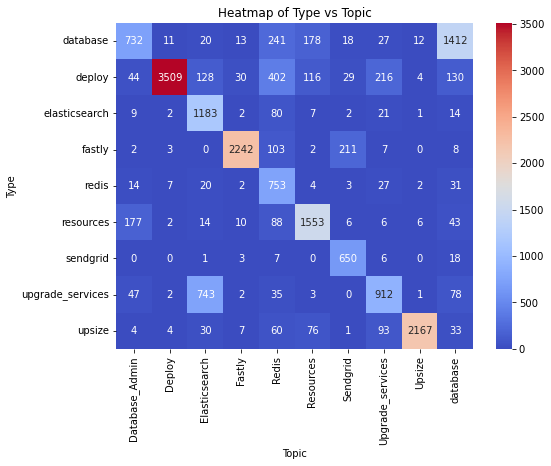

In [14]:
filtered_df['type'] = pd.Categorical(filtered_df['type'])
filtered_df['topic'] = pd.Categorical(filtered_df['topic'])

# Create a cross-tabulation of the two variables
cross_tab = pd.crosstab(filtered_df['type'], filtered_df['topic'])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cross_tab, annot=True, cmap='coolwarm', fmt='d')
plt.title('Heatmap of Type vs Topic')
plt.xlabel('Topic')
plt.ylabel('Type')
plt.show()

In [15]:
# Loading into a csv file
filtered_df.to_csv('nmf_categories_apr17.csv')

In [16]:
df_nmf = pd.read_csv('nmf_categories_apr17.csv')

In [17]:
df_nmf = df_nmf.rename(columns={'topic':'nmf'})
df_nmf = df_nmf.rename(columns={'type':'og'})

In [18]:
df_nmf.head()

,Unnamed: 0,text,og,tfidf_text,nmf
0,0,database project affect environment affect pro...,database,database project affect environment affect pro...,database
1,1,sql stick production seem like sql stuck produ...,database,sql stick production seem like sql stuck produ...,Database_Admin
2,2,database medium folder migration stage able re...,database,database medium folder migration stage able re...,database
3,3,sql server go away error log addition previous...,database,sql server go away error log previous message ...,Database_Admin
4,4,location fail graph overall elastic monitor si...,database,location fail graph elastic monitor sincerely ...,Fastly


In [19]:
# Rename categories
df_nmf['nmf'] = df_nmf['nmf'].str.lower()
df_nmf['nmf'] = df_nmf['nmf'].replace('upgrade', 'upgrade_services')
df_nmf['nmf'] = df_nmf['nmf'].replace('deployment_issues', 'deploy')
df_nmf['nmf'] = df_nmf['nmf'].replace('application_deployment_issues', 'app_deploy')
df_nmf['nmf'] = df_nmf['nmf'].replace('memory', 'redis')
# Recheck categories
print('nmf')
print(pd.unique(df_nmf['nmf']))
print('og')
print(pd.unique(df_nmf['og']))

nmf
['database' 'database_admin' 'fastly' 'redis' 'resources'
 'upgrade_services' 'upsize' 'sendgrid' 'elasticsearch' 'deploy']
og
['database' 'upgrade_services' 'elasticsearch' 'sendgrid' 'redis' 'fastly'
 'resources' 'upsize' 'deploy']


In [20]:
# Clarify independent and dependent variables
x = df_nmf['tfidf_text']
y = df_nmf[['og','nmf']]

# Split datasets into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state = 0)

# Define vectorizer
vectorizer = TfidfVectorizer()

# Vectorize xtrain and xtest
vector_xtrain = vectorizer.fit_transform(xtrain)
vector_xtest = vectorizer.transform(xtest)

In [21]:
# Produce a classification report
print(classification_report(y['og'], y['nmf']))

/Users/swap7898/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

        database       0.80      0.53      0.64      2664
  database_admin       0.00      0.00      0.00         0
          deploy       0.99      0.76      0.86      4608
   elasticsearch       0.55      0.90      0.68      1321
          fastly       0.97      0.87      0.92      2578
           redis       0.43      0.87      0.57       863
       resources       0.80      0.82      0.81      1905
        sendgrid       0.71      0.95      0.81       685
upgrade_services       0.69      0.50      0.58      1823
          upsize       0.99      0.88      0.93      2475

        accuracy                           0.76     18922
       macro avg       0.69      0.71      0.68     18922
    weighted avg       0.85      0.76      0.79     18922



/Users/swap7898/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/swap7898/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
# Create an empty DataFrame
df = pd.DataFrame()

# Assign the 'text' column from another DataFrame called 'filtered_df' to the 'text' column of this DataFrame
df['text'] = df_nmf['text']

# Assign the 'topic' column from 'filtered_df' to the 'input_type' column of this DataFrame
df['input_type'] = df_nmf['nmf']

In [34]:
from nltk.tokenize import word_tokenize
def tokenize_text(text):
    # Tokenize the text using NLTK's word_tokenize
    tokens = word_tokenize(text)
    return tokens

In [35]:
df['text'] = df['text'].apply(tokenize_text)

In [36]:
df

,text,input_type
0,"[database, project, affect, environment, affec...",database
1,"[sql, stick, production, seem, like, sql, stuc...",database_admin
2,"[database, medium, folder, migration, stage, a...",database
3,"[sql, server, go, away, error, log, addition, ...",database_admin
4,"[location, fail, graph, overall, elastic, moni...",fastly
...,...,...
18917,"[fashion, increase, stage, elastic, order, cre...",elasticsearch
18918,"[work, cache, clean, deploy, production, engin...",redis
18919,"[enable, fastly, like, probably, later, week, ...",sendgrid
18920,"[deploy, fail, go, backlog, notice, respond, a...",deploy


In [27]:
from collections import Counter

In [28]:

# Flatten the list of tokenized text into a single list of words
all_words = [word for sublist in df['text'] for word in sublist]

# Count the frequency of each word using Counter
word_freq = Counter(all_words)

# Convert the word frequency Counter object to a DataFrame for easy manipulation
word_freq_df = pd.DataFrame.from_dict(word_freq, orient='index', columns=['frequency'])

# Sort the DataFrame by frequency in descending order
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

# Optionally, you can reset the index to have the words as a column
word_freq_df.reset_index(inplace=True)
word_freq_df.rename(columns={'index': 'word'}, inplace=True)

In [30]:
# Now word_freq_df contains the frequency of each word in your tokenized text
word_freq_df.to_excel('words.xlsx')

In [31]:
# Read the words from an Excel file into a DataFrame
words = pd.read_excel('words.xlsx')

In [37]:
# Create a new DataFrame and assign 'text' and 'input_type' columns from df_nmf to it
df1 = pd.DataFrame()
df1['text'] = df_nmf['text']
df1['input_type'] = df_nmf['nmf']

# Display the newly created DataFrame
display(df1)

,text,input_type
0,database project affect environment affect pro...,database
1,sql stick production seem like sql stuck produ...,database_admin
2,database medium folder migration stage able re...,database
3,sql server go away error log addition previous...,database_admin
4,location fail graph overall elastic monitor si...,fastly
...,...,...
18917,fashion increase stage elastic order create se...,elasticsearch
18918,work cache clean deploy production engineering...,redis
18919,enable fastly like probably later week next we...,sendgrid
18920,deploy fail go backlog notice respond automati...,deploy


In [38]:
# Import necessary libraries
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
display(df1)

,text,input_type
0,database project affect environment affect pro...,database
1,sql stick production seem like sql stuck produ...,database_admin
2,database medium folder migration stage able re...,database
3,sql server go away error log addition previous...,database_admin
4,location fail graph overall elastic monitor si...,fastly
...,...,...
18917,fashion increase stage elastic order create se...,elasticsearch
18918,work cache clean deploy production engineering...,redis
18919,enable fastly like probably later week next we...,sendgrid
18920,deploy fail go backlog notice respond automati...,deploy


In [39]:
# Instantiate a CountVectorizer object
vectorizer = CountVectorizer()

In [40]:
# Fit and transform the 'text' column from df1
X = vectorizer.fit_transform(df1['text'])

In [41]:
# Convert the transformed data into a DataFrame
count_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

In [42]:
# Display the shape of the count_df DataFrame
count_df.shape

(18922, 7555)

In [43]:
# Reset the index of the df1 DataFrame for consistency
df1.reset_index(drop=True, inplace=True)

In [44]:
# Concatenate 'input_type' from df1 with count_df
result_df = pd.concat([df1['input_type'], count_df], axis=1)

In [45]:
# Convert the 'word' column from the words DataFrame into a list
df_words = words['word'].tolist()

KS TEST

In [46]:
from scipy import stats
import numpy as np
# Get unique values in the 'input_type' column
unique_input_types = result_df['input_type'].unique()

# Initialize a list to store the occurrence of p-value=1 for each word
score_list = []

# Iterate through each word
for word_df in df_words:

    # Initialize matrices 
    ks_matrix = np.zeros((len(unique_input_types), len(unique_input_types)))
    p_value_matrix = np.zeros((len(unique_input_types), len(unique_input_types)))

    # Iterate over unique input types
    for i in range(len(unique_input_types)):
        for j in range(len(unique_input_types)):
            # Get samples for the current combination of input types
            sample1 = result_df.loc[result_df['input_type'] == unique_input_types[i], word_df].values
            sample2 = result_df.loc[result_df['input_type'] == unique_input_types[j], word_df].values

            # Perform the KS two-sample test
            ks_statistic, p_value = stats.ks_2samp(sample1, sample2)

            # Assign KS statistic and p-value to the corresponding indices in the matrices
            ks_matrix[i, j] = ks_statistic
            
            # Modify p-value as per the condition
            if p_value < 0.1:
                p_value = 1
            else:
                p_value = 0
            p_value_matrix[i, j] = p_value

    # Count the occurrences of 1 in the modified p-value matrix
    score = np.count_nonzero(p_value_matrix == 1) / (len(unique_input_types)**2)
    score_list.append(score)

# Convert occurrence list to a DataFrame for visualization
score_df = pd.DataFrame({'Word': df_words, 'Score': score_list})


# Set the file path where you want to save the CSV file
file_path = 'NMFscores.csv'

# Save the DataFrame to a CSV file
score_df.to_csv(file_path, index=False)

In [48]:
#Using Bonferroni Correction
# Get unique values in the 'input_type' column
unique_input_types = result_df['input_type'].unique()

# Initialize a list to store the occurrence of significant results for each word
occurrence_list = []

# Initialize the number of comparisons made
num_comparisons = 45

# Iterate through each word
for word_df in df_words:

    # Initialize matrices 
    ks_matrix = np.zeros((len(unique_input_types), len(unique_input_types)))
    p_value_matrix = np.zeros((len(unique_input_types), len(unique_input_types)))

    # Iterate over unique input types
    for i in range(len(unique_input_types)):
        for j in range(len(unique_input_types)):
            # Get samples for the current combination of input types
            sample1 = result_df.loc[result_df['input_type'] == unique_input_types[i], word_df].values
            sample2 = result_df.loc[result_df['input_type'] == unique_input_types[j], word_df].values

            # Perform the KS two-sample test
            ks_statistic, p_value = stats.ks_2samp(sample1, sample2)

            # Assign KS statistic and p-value to the corresponding indices in the matrices
            ks_matrix[i, j] = ks_statistic
            
            # Adjust p-value using Bonferroni correction
            p_value_bonferroni = p_value * num_comparisons
            
            # Modify p-value as per the condition
            if p_value_bonferroni < 0.1:
                p_value_bonferroni = 1
            else:
                p_value_bonferroni = 0
            p_value_matrix[i, j] = p_value_bonferroni
            
            p_value_matrix[i, j] = p_value_bonferroni

    # Count the occurrences of significant results after Bonferroni correction
    score = np.count_nonzero(p_value_matrix == 1) / (len(unique_input_types)**2)
    occurrence_list.append(score)

# Convert occurrence list to a DataFrame for visualization
score_df_bon = pd.DataFrame({'Word': df_words, 'Score': occurrence_list})
# Save the DataFrame to a CSV file
score_df_bon.to_csv('NMFbon_score.csv', index=False)